# BLU15 - Model CSI


In [1]:
import pandas as pd
import numpy as np
import hashlib
import io
import json
import pickle
import requests
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

Alright, let's go on with the BLU and have fun doing some exercises!

<img src="media/show.jpg" width=300/>

As a reminder:

In the learning unit we received a pretrained model and a new batch of data and analyzed whether the model performs well and what to do with it.

In the end, we realized that there are some unexpected changes in the data distribution and we need to retrain the model.

As the new dataset was pretty small, we have to concat the old data with the new one and train a new model on the combination of 2 datasets.


## Exercise 1:

- Read the .csv file with the original dataframe as **df_old.**

- If you take a look on the **VehicleSearchedIndicator** column, you understand that this subset represents the searched cars only, so we can drop the **VehicleSearchedIndicator** column.

- As the new dataset doesn't contain **InterventionDateTime** column, we also need to drop it from the old dataset.

- Read new observations as **df_new**.

- Combine both the dataframes and add a new column called **is_new** that is going to have all **False** values for the old data and all **True** values for the new observations.

- Call the combined dataframe **df_combined**

- Drop all **NaN** values

- Apply lowercase to department names and intervention location names in the combined dataset

In [13]:
# df_old = ...
# df_new = ...
# df_combined = ...

# YOUR CODE HERE
df_old = pd.read_csv('./data/train_searched.csv').drop(['VehicleSearchedIndicator','InterventionDateTime'], axis=1)
df_old['is_new'] = False
df_old.head()

df_new = pd.read_csv('./data/new_observations.csv')
df_new['is_new'] = True

df_combined = df_old.append(df_new)

df_combined['Department Name'] = df_combined['Department Name'].str.lower()
df_combined['InterventionLocationName'] = df_combined['InterventionLocationName'].str.lower()

df_combined=df_combined.dropna()

df_combined

,ContrabandIndicator,Department Name,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator,is_new
0,False,bridgeport,bridgeport,V,1207,True,I,Speed Related,37.0,H,W,M,True,False
1,True,milford,milford,E,2325,True,I,Defective Lights,30.0,N,W,M,True,False
2,False,torrington,torrington,V,DACYR048,True,C,Registration,43.0,N,W,M,True,False
3,False,state police,tolland,V,1000002715,False,C,Other,19.0,N,B,M,False,False
4,False,greenwich,riverside,V,110993,False,N,Speed Related,34.0,M,B,M,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,True,berlin,berlin,V,JJS2844,True,I,Registration,34.0,H,W,M,False,True
1996,False,new britain,new britain,V,785,True,O,Traffic Control Signal,35.0,N,B,M,True,True
1997,False,seymour,seymour,I,345,True,I,Registration,59.0,N,W,F,True,True
1998,True,bristol,bristol,V,120000088,True,O,Moving Violation,37.0,N,W,M,True,True


In [14]:
assert df_combined.shape == (78715, 14), 'combined dataframe shape is wrong'
assert 'VehicleSearchedIndicator' not in df_combined.columns, 'Did you drop the VehicleSearchedIndicator column?'
assert 'is_new' in df_combined.columns, 'Did you add is_new column?'
assert sum(df_combined['is_new']) == 2000, 'is_new column has a wrong number of True values'
assert all([name.islower() for name in df_combined['Department Name']]), 'Department name is not lowercased'
assert all([name.islower() or not name.isalpha() for name in df_combined['InterventionLocationName']]), 'InterventionLocationName is not lowercased'

## Exercise 2:

**Split the created dataset on train and test parts in the following way:**

- Firstly create train and test set. Call them **df_train** and **df_test**.
> We'll need them in the future exercises. 
- Then, split **train** and **test** into **X_train**, **X_test**, **y_train** and **y_test**.
- Test sets shape should be 25% of df_combined shape
- Make sure to have 25% of new values in the test size.
- Use random state 42 while splitting the datasets

In [38]:
# YOUR CODE HERE
df_train, df_test = train_test_split(df_combined, test_size=0.25, random_state=42, stratify = df_combined['is_new'])

X_train = df_train.drop('ContrabandIndicator',axis=1)
X_test = df_test.drop('ContrabandIndicator',axis=1)
y_train = df_train.ContrabandIndicator
y_test = df_test.ContrabandIndicator

df_test.is_new.value_counts(normalize=True)

False    0.974592
True     0.025408
Name: is_new, dtype: float64

In [37]:
assert df_train.shape == (59036, 14), 'df_train shape is wrong. Are you sure test size is 25%?'
assert df_test.shape == (19679, 14), 'df_test shape is wrong. Are you sure test size is 25%?'
assert X_train.shape == (59036, 13), 'X_train shape is wrong. Are you sure test size is 25%?'
assert X_test.shape == (19679, 13), 'X_test shape is wrong. Are you sure test size is 25%?'
assert y_train.shape == (59036,), 'X_train shape is wrong. Are you sure test size is 25%?'
assert y_test.shape == (19679,), 'X_train shape is wrong. Are you sure test size is 25%?'
assert sum(X_train['is_new']) == 1500, 'is_new column in Training set has a wrong number of True values. Make sure to have 25% of new values'
assert sum(X_test['is_new']) == 500, 'is_new column in Test set has a wrong number of True values. Make sure to have 25% of new values'

Now we need to retrain the model.

If we simply load the pipeline and retrain it, it's going to ignore our new feature.

So let's create the same pipeline as in the original notebook:

In [100]:
categorical_features = df_combined.columns.drop(['ContrabandIndicator', 'SubjectAge'])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(
    preprocessor,
    LGBMClassifier(n_jobs=-1, random_state=42),
)

In [99]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Department Name', 'InterventionLocationName', 'InterventionReasonCode',
       'ReportingOfficerIdentificationID', 'ResidentIndicator',
       'SearchAuthorizationCode', 'StatuteReason', 'SubjectEthnicityCode',
       'SubjectRaceCode', 'SubjectSexCode', 'TownResidentIndicator', 'is_new'],
      dtype='object'))])),
                ('lgbmclassifier', LGBMClassifier(random_

## Exercise 3:

Now let's test how the model performs:

- Make model binary predictions and save them to an array **preds**. 
- Make model probability predictions and save them to an array called **preds_proba**. Keep only True class probabilities (by default probability prediction returns you both False and True classes probabilities)
- Create a variable called **precision** with the model precision score.
- Create a variable called **recall** with the model recall score

In [69]:
# YOUR CODE HERE

preds = pipeline.predict(X_test)
preds_proba = pipeline.predict_proba(X_test)[:,1]

precision = precision_score(y_test, preds, pos_label=True)
recall = recall_score(y_test, preds, pos_label=True)
print(precision)
print(recall)

0.6496610774170531
0.5460269865067466


In [72]:
expected_recall = 'a2cffa866c48b997372a62104161ba89e68fb439c418fc2559e2a32c44987ce8'
hash_recall = hashlib.sha256(bytes(str(round(recall, 2)), encoding='utf8')).hexdigest()
assert hash_recall == expected_recall

In [73]:
assert len(preds) == 19679, 'Are you sure you made predictions for test set only?'
assert len(preds_proba) == 19679, 'Are you sure you made predictions for test set only?'
assert not isinstance(preds_proba[0], np.ndarray), 'Are you sure you kept only the True class predictions?'
assert round(sum(preds_proba)) == 6563
np.testing.assert_almost_equal(precision, 0.64966, decimal=2)
np.testing.assert_almost_equal(recall, 0.546027, decimal=2)


## Exercise 4: 

It's already not bad, but let's now try to calculate the optimal threshold.

By threshold I mean the minimal probability of a prediction that we're going to call "True". 

By default, any prediction with probability > 0.5 is called True, but we might find a better value. 

The metric is the same: our success rate (precision) needs to be at least 50%, and the recall should be as big as possible. 

Save the result to a variable called **threshold**. Round the result to 2 decimal points.

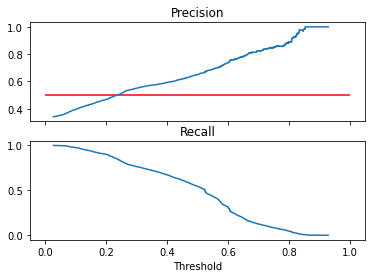

4160
0.2371131147664353
0.5
0.8493253373313343


In [83]:
# threshold = ...
# YOUR CODE HERE

precision_, recall_, thresholds = precision_recall_curve(y_test, preds_proba)
precision_ = precision_[:-1]
recall_ = recall_[:-1]

import matplotlib.pyplot as plt
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision_)
ax2.plot(thresholds,recall_)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()

min_index = [i for i, prec in enumerate(precision_) if prec >= 0.5][0]
print(min_index)

print(thresholds[min_index])
print(precision_[min_index])
print(recall_[min_index])

threshold = round(thresholds[min_index],2)

In [84]:
assert round(threshold, 2) == threshold, 'Did you round the value?'
ans_threshold = hashlib.sha256(bytes(str(threshold), encoding='utf8')).hexdigest()
assert ans_threshold == "6382e07f9de0c85293aee2a45b88c61c28589419682ecc2f8c097f750e861a24"

## Exercise 5:

- Now create a list of predictions. 

> All the values from the **preds_proba** list that have a value > threshold should be True. The rest should be False.

> Save the result to a variable called **best_preds**

- Calculate the precision and recall and save them to variables **precision** and **recall**

In [91]:
# best_preds = ...
# precision = ...
# recall = ...
# YOUR CODE HERE

best_preds = []
for i in preds_proba:
    if i > threshold:
        best_preds.append(True)
    else:
        best_preds.append(False)

best_preds = np.array(best_preds)

precision = precision_score(y_test, best_preds, pos_label=True)
recall = recall_score(y_test, best_preds, pos_label=True)

print(precision)
print(recall)

0.5029025631865678
0.8442278860569715


In [92]:
np.testing.assert_almost_equal(precision, 0.50290256, decimal=2)
np.testing.assert_almost_equal(recall, 0.84422789, decimal=2)

## Exercise 6:

Now let's find out whether removing rare values is going to help. 

**Filter *df_train* (the one you created in the Exercise 2) the following way:** 

- Remove rows with **Department Name** that appear <= 50 times
- Remove rows with **InterventionLocationName** that appear <= 50 times
- Remove rows with **ReportingOfficerIdentificationID** that appear <= 30 times
- Remove rows with **StatuteReason** that appear <= 10 times
- Note: it's better to keep the original dataframe not touched. Create a copy of the original dataframe and save the results to a variable **train_filtered**

> We have to filter the values after we split the dataset into training and test, because by filtering the test set we also affect the score. If we filtered everything besides the examples that are the easiest to predict, we'd have a super nice score, but in production we're going to expect both the filtered values and unfiltered ones. 

> We shouldn't worry about the fact, that some values in the test set will not be present in the training set, because the pipeline is simply going to ignore them.

> (you might use the logic from the original model's notebook, but I suggest trying to implement it by yourself, it's a good exercise)

In [93]:
train_filtered = df_train.copy()
# train_filtered = ...

# YOUR CODE HERE
min_frequency = {
    "Department Name": 50,
    "InterventionLocationName": 50,
    "ReportingOfficerIdentificationID": 30,
    "StatuteReason": 10
}

def filter_values(df: pd.DataFrame, column_name: str, threshold: int):
    value_counts = df[column_name].value_counts()
    to_keep = value_counts[value_counts > threshold].index
    filtered = df[df[column_name].isin(to_keep)]
    return filtered

for feature, threshold in min_frequency.items():
    train_filtered = filter_values(train_filtered, feature, threshold)

In [94]:
assert train_filtered.shape == (30502, 14), 'Make sure to filter rare values. Make sure to filter only train set.'
assert 'middlebury' not in train_filtered['Department Name'], 'Did you filter department names?'
assert 'hampton' not in train_filtered['InterventionLocationName'], 'Did you filter InterventionLocationName ?'
assert 'DACYR048' not in train_filtered['ReportingOfficerIdentificationID'], 'Did you filter officer ids?'
assert 'Stop Sign ' not in train_filtered['StatuteReason'], 'Did you filter statute reasons?'

## Exercise 7:

**Let's split *train_filtered* into *X* and *Y* parts and do the same thing once again:**

- Fit the model on the training set (this time filtered one)

- Predict probabilities for the test set (untouched one).

- Select the best threshold for the specified requirements (precision >= 0.5, max possible recall).

- Round up the threshold up to 2 decimal points.

- Transform probabilities to binary answers: probability above the threshold = True, False otherwise.

- Calculate the precision and recall scores for these predictions. 

I believe you need no exact instructions, as you did exactly same things in Exercises 2, 3 and 4.

Save the score results to variables called **filtered_precision** and **filtered_recall**

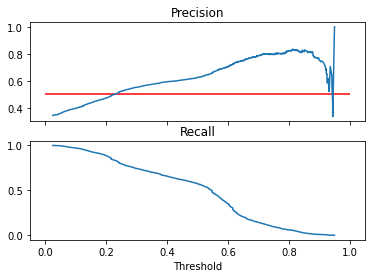

0.5013092550790068
0.832383808095952


In [104]:
# YOUR CODE HERE

#Fit the model on the training set (this time filtered one)
X_train_filtered = train_filtered.drop('ContrabandIndicator',axis=1)
y_train_filtered = train_filtered.ContrabandIndicator

pipeline.fit(X_train_filtered, y_train_filtered)

#Predict probabilities for the test set (untouched one).
preds = pipeline.predict(X_test)
preds_proba = pipeline.predict_proba(X_test)[:,1]

#Select the best threshold for the specified requirements (precision >= 0.5, max possible recall).
precision_, recall_, thresholds = precision_recall_curve(y_test, preds_proba)
precision_ = precision_[:-1]
recall_ = recall_[:-1]

import matplotlib.pyplot as plt
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision_)
ax2.plot(thresholds,recall_)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()

min_index = [i for i, prec in enumerate(precision_) if prec >= 0.5][0]
# print(min_index)
# print(thresholds[min_index])
# print(precision_[min_index])
# print(recall_[min_index])

#Round up the threshold up to 2 decimal points.
threshold = round(thresholds[min_index],2)

#Transform probabilities to binary answers: probability above the threshold = True, False otherwise.
best_preds = []
for i in preds_proba:
    if i > threshold:
        best_preds.append(True)
    else:
        best_preds.append(False)

best_preds = np.array(best_preds)

#Calculate the precision and recall scores for these predictions.
filtered_precision = precision_score(y_test, best_preds, pos_label=True)
filtered_recall = recall_score(y_test, best_preds, pos_label=True)

print(filtered_precision)
print(filtered_recall)


In [105]:
np.testing.assert_almost_equal(filtered_precision, 0.501309, decimal=2)
np.testing.assert_almost_equal(filtered_recall, 0.83238, decimal=2)

Okay, so it seems like the original notebook had a mistake of evaluating the model on filtered test set. In fact, filtering features with these frequency limits decreased the recall (0.844 -> 0.832). 

## Exercise 8:
    
Now I'll let you use your fantasy and try to filter the categorical values differently. 

You're free to do whatever you want, but here are a few ideas you can use:

- Instead of dropping rare categories, create a new value for them

- Adjust the frequency values (e.g. keep a part of departments we just filtered or filter even more). You can try to search all the possible combinations of frequency values if you want. 

Your task is to create a list of *True/False* predictions for the **X_test** and call them **best_preds**. These predictions have to have precision >= 0.5 and recall > 0.84422789

In [110]:
# predictions = ...
# YOUR CODE HERE

train_filtered_ex8 = df_train.copy()
# train_filtered = ...

# YOUR CODE HERE
min_frequency = {
    "Department Name": 10,
    "InterventionLocationName": 10,
    "ReportingOfficerIdentificationID": 10,
    "StatuteReason": 10
}


for feature, threshold in min_frequency.items():
    train_filtered_ex8 = filter_values(train_filtered_ex8, feature, threshold)
    
#Fit the model on the training set (this time filtered one)
X_train_filtered_ex8 = train_filtered_ex8.drop('ContrabandIndicator',axis=1)
y_train_filtered_ex8 = train_filtered_ex8.ContrabandIndicator

pipeline.fit(X_train_filtered_ex8, y_train_filtered_ex8)

#Predict probabilities for the test set (untouched one).
preds = pipeline.predict(X_test)
preds_proba = pipeline.predict_proba(X_test)[:,1]

#Select the best threshold for the specified requirements (precision >= 0.5, max possible recall).
precision_, recall_, thresholds = precision_recall_curve(y_test, preds_proba)
precision_ = precision_[:-1]
recall_ = recall_[:-1]

min_index = [i for i, prec in enumerate(precision_) if prec >= 0.5][0]
threshold = round(thresholds[min_index],2)

#Transform probabilities to binary answers: probability above the threshold = True, False otherwise.
best_preds = []
for i in preds_proba:
    if i > threshold:
        best_preds.append(True)
    else:
        best_preds.append(False)

best_preds = np.array(best_preds)

#Calculate the precision and recall scores for these predictions.
filtered_precision = precision_score(y_test, best_preds, pos_label=True)
filtered_recall = recall_score(y_test, best_preds, pos_label=True)

print(filtered_precision)
print(filtered_recall)

0.5006657789613849
0.8455772113943029


In [111]:
precision = precision_score(y_test, best_preds)
recall = recall_score(y_test, best_preds)
assert precision >= 0.5
assert recall > 0.84422789

## Exercise 9:

So, we got the model. It's usually a good idea to retrain the model on the whole dataset, so now I want you to:
- Apply the filters that you just created in the Exercise 7 to **df_combined**
- Train the same model on the whole dataset
- Export the model, train columns and data types to **/tmp/<file_name>**, where files are called **new_pipeline.pickle**, **new_dtypes.pickle** and **new_columns.json**.

In [115]:
# YOUR CODE HERE
df_combined_filtered = df_combined.copy()

min_frequency = {
    "Department Name": 10,
    "InterventionLocationName": 10,
    "ReportingOfficerIdentificationID": 10,
    "StatuteReason": 10
}


for feature, threshold in min_frequency.items():
    df_combined_filtered = filter_values(df_combined_filtered, feature, threshold)
    
#Fit the model on the training set (this time filtered one)
X_train_filtered_ex9 = df_combined_filtered.drop('ContrabandIndicator',axis=1)
y_train_filtered_ex9 = df_combined_filtered.ContrabandIndicator

pipeline.fit(X_train_filtered_ex9, y_train_filtered_ex9)

with open('/tmp/new_columns.json', 'w') as fh:
    json.dump(X_train_filtered_ex9.columns.tolist(), fh)

with open("/tmp/new_dtypes.pickle", 'wb') as fh:
    pickle.dump(X_train_filtered_ex9.dtypes, fh)
    
joblib.dump(pipeline, '/tmp/new_pipeline.pickle')

['/tmp/new_pipeline.pickle']

In [116]:
with open('/tmp/new_columns.json') as fh:
    columns = json.load(fh)


with open('/tmp/new_pipeline.pickle', 'rb') as fh:
    pipeline = joblib.load(fh)


with open('/tmp/new_dtypes.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)

assert isinstance(columns, list), 'columns need to be a list of training features'
assert 'ContrabandIndicator' not in columns, 'there should be only training features in columns. You got target there.'
assert 'is_new' in columns, "your columns don't contain is_new feature. Are you you updated the columns file?"
assert isinstance(pipeline, Pipeline), 'new_pipeline.pickle does not seem it be an instance of Pipeline class.'
assert isinstance(dtypes, pd.core.series.Series)
assert all([column in dtypes.index for column in columns]), 'some columns from new_columns file are not in the new_dtypes file'
assert all([dtype in columns for dtype in dtypes.index]), 'some dtypes from new_dtypes file are not in the new_columns file'

## Exercise 10:

And now it's time to change the server! I know you missed this part :) 

Before we do it, I want to remind you, that in this exercise we didn't cover the ethics topic.

Our model is trained on sensible features like race, sex and ethnicity. 

In real situation you'd need to make sure that your model is not discriminating anyone. 

Now, go and create a copy of the **protected_server.py** file. Call it **new_server.py**

In that file:
- Change the **check_valid_column** function to have the new added columns

> You can also automate it by reading the columns file, it's even better!

- Change the **check_categorical_values** function:

> We didn't really affect any of the checked columns there besides **StatuteReason** (of course, if you didn't change it in your best solution). Remove the values that should not be in this column anymore.

> We also add one more categorical feature to the dataframe (**is_new**). Go and add possible values to the check.

- As soon as it's done, go ahead and start the server. 

- Play with the predictions. Make sure that the server checks the **is_new** feature values. Try to send requests without **is_new** or with a different value (not True or False). 

- After you're done, change the value of **done** to **True** to pass the exercise

In [117]:
done = True

In [118]:
# YOUR CODE HERE


In [119]:
assert done == True

Aaaaaand...we're done!

<img src="media/congrats.png" width=300/>